In [11]:
"""A multi-layer perceptron for classification of MNIST handwritten digits."""
from __future__ import absolute_import, division
from __future__ import print_function
import autograd.numpy as np
import autograd.numpy.random as npr
from autograd.scipy.misc import logsumexp
from autograd import grad
from autograd.util import flatten
from autograd.optimizers import adam
from data import load_mnist
%matplotlib inline

In [4]:
def init_random_params(scale, layer_sizes, rs=npr.RandomState(0)):
    """Build a list of (weights, biases) tuples,
       one for each layer in the net."""
    return [(scale * rs.randn(m, n),   # weight matrix
             scale * rs.randn(n))      # bias vector
            for m, n in zip(layer_sizes[:-1], layer_sizes[1:])]

def neural_net_predict(params, inputs):
    """Implements a deep neural network for classification.
       params is a list of (weights, bias) tuples.
       inputs is an (N x D) matrix.
       returns normalized class log-probabilities."""
    for W, b in params:
        outputs = np.dot(inputs, W) + b
        inputs = np.tanh(outputs)
    return outputs - logsumexp(outputs, axis=1, keepdims=True)

def l2_norm(params):
    """Computes l2 norm of params by flattening them into a vector."""
    flattened, _ = flatten(params)
    return np.dot(flattened, flattened)

def log_posterior(params, inputs, targets, L2_reg):
    log_prior = -L2_reg * l2_norm(params)
    log_lik = np.sum(neural_net_predict(params, inputs) * targets)
    return log_prior + log_lik

def accuracy(params, inputs, targets):
    target_class    = np.argmax(targets, axis=1)
    predicted_class = np.argmax(neural_net_predict(params, inputs), axis=1)
    return np.mean(predicted_class == target_class)

In [8]:
if True:
    # Model parameters
    layer_sizes = [784, 200, 100, 10]
    L2_reg = 1.0

    # Training parameters
    param_scale = 0.1
    batch_size = 256
    num_epochs = 10
    step_size = 0.001

    print("Loading training data...")
    N, train_images, train_labels, test_images,  test_labels = load_mnist()

    init_params = init_random_params(param_scale, layer_sizes)

    num_batches = int(np.ceil(len(train_images) / batch_size))
    def batch_indices(iter):
        idx = iter % num_batches
        return slice(idx * batch_size, (idx+1) * batch_size)

    # Define training objective
    def objective(params, iter):
        idx = batch_indices(iter)
        return -log_posterior(params, train_images[idx], train_labels[idx], L2_reg)

    # Get gradient of objective using autograd.
    objective_grad = grad(objective)

    acc = []
    print("     Epoch     |    Train accuracy  |       Test accuracy  ")
    def print_perf(params, iter, gradient):
        if iter % num_batches == 0:
            train_acc = accuracy(params, train_images, train_labels)
            test_acc  = accuracy(params, test_images, test_labels)
            acc.append((train_acc, test_acc))
            print("{:15}|{:20}|{:20}".format(iter//num_batches, train_acc, test_acc))

    # The optimizers provided can optimize lists, tuples, or dicts of parameters.
    optimized_params = adam(objective_grad, init_params, step_size=step_size,
                            num_iters=num_epochs * num_batches, callback=print_perf)

Loading training data...
     Epoch     |    Train accuracy  |       Test accuracy  
              0|     0.0939333333333|              0.0898
              1|      0.909083333333|              0.9148
              2|      0.913266666667|              0.9171
              3|      0.917233333333|              0.9204
              4|      0.920783333333|              0.9243
              5|      0.924383333333|              0.9277
              6|             0.92765|              0.9304
              7|      0.930083333333|               0.933
              8|      0.932233333333|              0.9343
              9|      0.933833333333|              0.9357


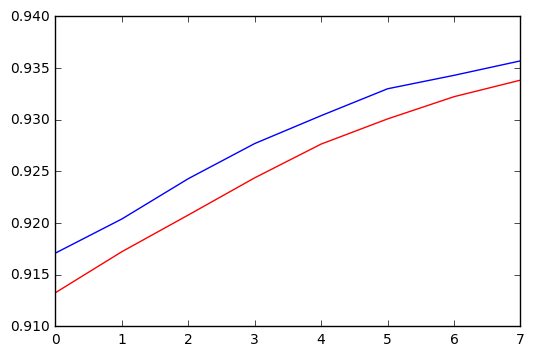

In [23]:
acc1 = acc[1:]
plot(range(len(acc1)), [t[0] for t in acc1], 'r', [t[1] for t in acc1], 'b')